In [1]:
import sys
sys.path.append("../script/")

from sklearn.metrics import classification_report,accuracy_score,balanced_accuracy_score,f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import importlib
from time import time
import Functions
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeClassifier

import numpy as np
import pandas as pd
from time import time

In [2]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.utils import shuffle
def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    print(roc_auc_score(true_y,prob[:,1]))

# Estimator

In [3]:
class Estimator:
    def __init__(self,bins=None,lam=None):
        self.bins = bins
        self.lam = lam

    def set_bins_params(self,val):
        bins = self.bins
        val_max = np.max(val)
        val_min = np.min(val)
        width = ((val_max - val_min)/bins)

        self.val_min = val_min
        self.width = width

    def fit(self,val,residual,p):
        self.set_bins_params(val)
        index = self.get_index(val)

        residual_bin = np.stack([np.sum(residual[index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[index==i],1-p[index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))
        
        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin
        
        grads = self.get_grads(index)

        return grads


    def get_index(self,val):
        index = ((val - self.val_min)//self.width).astype('int32') if self.width !=0 else np.zeros(val.shape[0])
        index = np.where(index >= self.bins,self.bins-1,index)
        index = np.where(index < 0,0,index)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

# Decision Tree Estimator

In [4]:
class Estimator_DC:
    def __init__(self,max_depth=None,lam=None):
        self.max_depth = max_depth
        self.lam = lam

    def set_grads_bin(self,residual,p):
        residual_bin = np.stack([np.sum(residual[self.index==i],axis=0) for i in range(self.bins)])
        cover_bin = np.stack([np.sum(np.multiply(p[self.index==i],1-p[self.index==i]),axis=0) for i in range(self.bins)])
        cover_bin = cover_bin + self.lam #lambda

        grad_bin = np.divide(residual_bin,cover_bin,where=cover_bin!=0,out=np.zeros(cover_bin.shape))

        self.residual_bin = residual_bin
        self.cover_bin = cover_bin
        self.grad_bin = grad_bin

        return self.get_grads(self.index)

    def fit(self,val,y):
        val = val.reshape(-1,1)

        self.clf = DecisionTreeClassifier(max_depth=self.max_depth,class_weight='balanced')
        # self.clf = DecisionTreeClassifier(max_depth=self.max_depth,class_weight={0:1,1:1,2:1})
        # self.clf = DecisionTreeClassifier(max_depth=self.max_depth)
        self.clf.fit(val,y)
        self.index = self.get_index(val)
        
        self.bins = len(self.clf.tree_.threshold)

    # def get_loss(self,base_gini):
    #     self.loss = -(base_gini - np.sum(self.clf.tree_.impurity))

    #     return self.loss

    def get_loss(self):
        impurity = self.clf.tree_.impurity[self.clf.tree_.children_right == -1]
        weighted_node = self.clf.tree_.weighted_n_node_samples[self.clf.tree_.children_right == -1]

        self.loss = impurity@(weighted_node/sum(weighted_node))

        # self.loss = self.clf.tree_.impurity@(self.clf.tree_.weighted_n_node_samples/sum(self.clf.tree_.weighted_n_node_samples))
        # self.loss = self.clf.tree_.impurity@(self.clf.tree_.n_node_samples/sum(self.clf.tree_.n_node_samples))
        return self.loss

    # def get_loss(self,grads,log_odds,p,learning_rate):
        # log_odds_1 = log_odds + learning_rate * grads
        
        # p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
        # p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
        
        # self.loss = np.sum(np.power(self.Y - p_1,2))
        # self.loss = -np.sum(np.power(self.p - p_1,2))
        # self.loss = -np.sum(np.abs(grads))
    #     return self.loss

    def get_index(self,val):
        val = val.reshape(-1,1)
        index = self.clf.apply(val)

        return index

    def get_grads(self,index):
        grads = np.zeros((index.shape[0],self.grad_bin.shape[1]))
        for i in range(self.bins):
            grads[index==i] = self.grad_bin[i]
        return grads


    def predict_grad(self,val):
        index = self.get_index(val)
        grads = self.get_grads(index)
        return grads

In [5]:
X = np.array([1,2,3,4,8,9]).reshape(-1,1)
y = np.array([0,0,0,0,1,1])

sample = {0:1,1:1}

In [6]:
# sample = {0:0.1,1:1,2:1}
sample = [0.1,1,1]

In [7]:
clf = DecisionTreeClassifier(max_depth=1,class_weight='balanced')
clf.fit(X,y)

DecisionTreeClassifier(class_weight='balanced', max_depth=1)

In [8]:
1 * 2/3 * 1/3 + 1/3*2/3

0.4444444444444444

In [9]:
tree = stack[0].estimator.clf.tree_

NameError: name 'stack' is not defined

In [10]:
(tree.impurity*(tree.n_node_samples/sum(tree.n_node_samples)))[tree.children_right == -1]

NameError: name 'tree' is not defined

In [11]:
tree.impurity[tree.children_right == -1]

NameError: name 'tree' is not defined

In [313]:
clf.tree_.threshold,clf.tree_.impurity,clf.tree_.n_node_samples

(array([11.5, -2. , -2. ]),
 array([0.875     , 0.8604566 , 0.28119458]),
 array([100968,  62924,  38044], dtype=int64))

In [274]:
clf.tree_.impurity@(clf.tree_.n_node_samples/sum(clf.tree_.n_node_samples))

0.7585974650222032

In [254]:
clf.tree_.weighted_n_node_samples

array([100968.00000001,  87304.89206008,  13663.10793995])

# Node

In [12]:
class Node:
    def __init__(self,terminal,func=None,sons=None,index=None,fit=None,estimator=None):
        self.terminal = terminal
        self.sons = sons
        self.func = func
        self.index = index
        self.fitness = fit
        self.estimator = estimator
        if self.terminal:
            self.depth = 0
            self.numNode = 1
        else:
            self.depth = max([s.depth for s in sons]) + 1
            self.numNode = sum([s.numNode for s in sons])+ 1

    def predict_grad(self,X):
        val = self.predict_val(X)
        return self.estimator.predict_grad(val)
        
    def predict_val(self,X):
        X = X.astype('float64')
        return self.pred_rec(X.T)
    def pred_rec(self,X):
        if not self.terminal:
            return self.func([s.pred_rec(X) for s in self.sons])
        else:
            return X[self.index]
    def __str__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string
    def __repr__(self):
        if self.terminal:
            return "|"+str(self.index)+"|"
        else:
            string = "( " + str(self.func.__name__) + " -> "
            for s in self.sons:
                string += str(s) + " "
            string += ")"
            return string

# Engine

In [13]:
class Engine:
    def __init__(self,opset,X,Y,Y_one_hot,log_odds,p,learning_rate,bins):
        self.generation = 0
        
        X = X.astype('float64')
        self.opset = opset
        
        self.feature_space = X.shape[1]
        
        self.vals = X.T
        self.X = X
        self.Y = Y
        self.Y_one_hot = Y_one_hot

        base_gini = (pd.value_counts(Y)/Y.shape)
        self.base_gini = sum(base_gini*(1-base_gini))

        self.log_odds = log_odds
        self.p = p
        self.residual = Y_one_hot - p
        self.learning_rate = learning_rate
        self.bins = bins
        
        self.best = (np.inf,None)
        self.nodes = [Node(True,index=i) for i in range(self.feature_space)]
    
    # def calculate_grad(self,val,lam):
    #     bins = self.bins
    #     val_max = np.max(val)
    #     val_min = np.min(val)
    #     width = ((val_max - val_min)/bins)

    #     index = ((val - val_min)//width).astype('int32') if width != 0 else np.zeros(val.shape[0])
    #     index = np.where(index >= bins,bins-1,index)
    #     index = np.where(index < 0,0,index)

    #     residual_bin = np.stack([np.sum(self.residual[index==i],axis=0) for i in range(bins)])
    #     p_bin = np.stack([np.sum(np.multiply(self.p[index==i],1-self.p[index==i]),axis=0) for i in range(bins)]) + lam
    #     grad_bin = np.divide(residual_bin,p_bin,where=p_bin!=0,out=np.zeros(p_bin.shape))

    #     grads = np.zeros(self.log_odds.shape)
    #     for i in range(bins):
    #         grads[index==i] = grad_bin[i]
            
    #     return grads

    
    def calculate_fitness(self,vals,lam=0,max_depth=3):
        fitness = []
        estimators = []
        for val in vals:
            # est = Estimator(self.bins,lam)
            # grads = est.fit(val,self.residual,self.p)
            est = Estimator_DC(max_depth,lam)
            est.fit(val,self.Y)

            # grads = est.set_grads_bin(self.residual,self.p)
            # loss = est.get_loss(grads,self.log_odds,self.p,self.learning_rate)

            # loss = est.get_loss(self.base_gini)
            
            loss = est.get_loss()
            
            fitness.append(loss)
            estimators.append(est)

        return fitness,estimators
    

    def evolve(self,total_size,batch_size,elite_size,lam=0,max_depth=3,verbose=0):
        self.generation += 1
        
        if verbose:
            print("\tgeneration:",self.generation)
            t = time()
        
        num_batches = total_size//batch_size
        pool = self.nodes

        elites_funcs = []
        elite_sons = []
        elite_vals = []

        elites_fitness = []
        elites_estimator = []

        for j in range(num_batches):

            funcs = np.random.choice(list(self.opset.keys()),size=batch_size)
            arg_count = [self.opset[func] for func in funcs]
            sons = np.random.choice(pool,size = sum(arg_count))
            it = iter(sons)
            sons = [[next(it) for _ in range(arg_count[i])] for i in range(batch_size)]
            vals = [funcs[i]([self.vals[s.index] for s in sons[i]]) for i in range(batch_size)]

            vals = np.stack(vals)
            fitness,estimators = self.calculate_fitness(vals,lam,max_depth)
            # fitness = self.calculate_decision(vals,1,lam)
            
            elites_funcs.extend(funcs)
            elite_sons.extend(sons)
            elite_vals.extend(vals)
            elites_fitness.extend(fitness)
            elites_estimator.extend(estimators)

            rank = np.argsort(elites_fitness)

            elites_funcs = [elites_funcs[index] for index in rank[:elite_size]]
            elite_sons = [elite_sons[index] for index in rank[:elite_size]]
            elite_vals = [elite_vals[index] for index in rank[:elite_size]]
            elites_fitness = [elites_fitness[index] for index in rank[:elite_size]]
            elites_estimator = [elites_estimator[index] for index in rank[:elite_size]]

        for index in range(elite_size):
            node = Node(False,
                func=elites_funcs[index],
                sons=elite_sons[index],
                index=len(self.nodes),
                fit=elites_fitness[index],
                estimator=elites_estimator[index]
            )
            if index == 0:
                if self.best[0] > node.fitness:
                    self.best = (node.fitness,node)
            self.nodes.append(node)
            self.vals = np.append(self.vals,[elite_vals[index]],axis=0)
            # self.test_param_same(node)
      

        if verbose:
            print("\t",np.max(elites_fitness))
            print("\ttime",time()-t)
        return None

    def test_param_same(self,node):
        v1 = node.predict_val(self.X)
        v2 = self.vals[node.index]
        if np.any(v1!=v2):
            print(node.index,v1==v2)

# Stack

In [14]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

In [15]:
def adding_unique_node(stack,losses,new_nodes,tolerance):
    protect_losses = [-np.inf] + losses + [np.inf]
    protect_stack = [None] + stack + [None]
    new_losses = [ node.estimator.loss for node in new_nodes]

    for i in range(len(new_losses)):
        new_loss = new_losses[i]
        new_node = new_nodes[i]
        
        index = np.searchsorted(protect_losses,new_loss,side='left')
        left_index = index - 1
        right_index = index 

        left_diff = new_loss - protect_losses[left_index]
        left_node = protect_stack[left_index]

        right_diff = protect_losses[right_index] - new_loss
        right_node = protect_stack[right_index]

        mid_flag,left_flag,right_flag = (1,1,1)

        if left_diff < tolerance:
            if left_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                left_flag = 0
        if right_diff < tolerance:
            if right_node.numNode <= new_node.numNode:
                mid_flag = 0
            else:
                right_flag = 0
        
        if mid_flag == 1:
            if right_flag == 0:
                protect_stack.pop(right_index)
                protect_losses.pop(right_index)
                
            protect_stack.insert(index,new_node)
            protect_losses.insert(index,new_loss)

            if left_flag == 0:
                protect_stack.pop(left_index)
                protect_losses.pop(left_index)
    
    losses = protect_losses[1:-1]
    stack = protect_stack[1:-1]

    return stack,losses

In [16]:
def to_one_hot(y,yt):
    le = LabelEncoder()
    ohe = OneHotEncoder()
    y_train = le.fit_transform(y)
    y_one_hot = ohe.fit_transform(y_train.reshape(-1,1))
    
    y_test = le.transform(yt)
    yt_one_hot = ohe.transform(y_test.reshape(-1,1))
    
    return y_train,y_test,y_one_hot,yt_one_hot

def initial(y_one_hot):
    init_log_odds = np.sum(y_one_hot,axis=0)/y_one_hot.shape[0]
    
    init_p = np.exp(init_log_odds)
    init_p = init_p/(1+init_p)

    return init_log_odds,init_p

def initial_first_bin(init_log_odds,init_p,X):
    log_odds = np.repeat(init_log_odds,X.shape[0],0)
    p = np.repeat(init_p,X.shape[0],0)
    
    return log_odds,p
    
def update_log_p(grads,log_odds,p,learning_rate):
    log_odds_1 = log_odds + learning_rate * grads
    
    p_1 = np.exp(log_odds_1,where=log_odds_1 < 16,out=np.zeros(log_odds_1.shape)+16)
    p_1 = np.divide(p_1,(1+p_1),where=p_1 < 16,out=np.ones(p_1.shape))
    
    # p_1 = np.exp(log_odds_1)
    # p_1 = np.divide(p_1,(1+p_1))

    return log_odds_1,p_1

def predict(X,init_log_odds,init_p,learning_rate,stack):
    log_odds,p = initial_first_bin(init_log_odds,init_p,X)

    for node in stack:
        grads = node.predict_grad(X)
        
        log_odds,p = update_log_p(grads,log_odds,p,learning_rate)
    return p

# Data

In [17]:
df = pd.read_csv("../data/fars.tsv",delimiter='\t')
X = df.iloc[:,:-1].to_numpy().astype("float")
y = df.iloc[:,-1].to_numpy().astype("int")

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5,stratify=y)

In [14]:
feature_space = X_train.shape[1]
y_train,y_test,y_train_one_hot,y_test_one_hot = to_one_hot(y_train,y_test)

learning_rate = 0.3
lam = 1
max_depth = 6
bins = 10

init_log_odds,init_p = initial(y_train_one_hot)
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)

stack = []
losses = []

for i in range(feature_space):
    val = X_train[:,i]
    est = Estimator_DC(max_depth,lam)
    est.fit(val,y_train)
    loss = est.get_loss()

    node = Node(terminal=True,index=i,fit=loss,estimator=est)
    stack.append(node)
    losses.append(loss)
index = np.argsort(losses)
losses = [losses[i] for i in index]
stack = [stack[i] for i in index]

In [337]:
tolerance = min([losses[i] - losses[i-1] for i in range(1,len(losses))])/5
# tolerance = 0.000001
i = 0

epoch = 10

total = 10
elite = 3


while len(stack) < 20000:
        eg = Engine(Functions.simple_opset,X_train,y_train,y_train_one_hot,log_odds,p,learning_rate,bins)
        for j in range(epoch):
                eg.evolve(total,total,elite,lam,max_depth,0)
        # s.extend([eg.best[1]])
        newcomers = eg.nodes[-elite*epoch:]
        stack,losses = adding_unique_node(stack,losses,newcomers,tolerance)

        print(i,len(stack),sum([n.numNode for n in stack]))
        i += 1

0 1052 7658
1 1077 7833
2 1105 8155
3 1129 8311
4 1156 8594
5 1181 8765
6 1208 9046
7 1234 9300
8 1260 9562
9 1283 9741
10 1310 9922
11 1332 10062
12 1359 10313
13 1385 10495
14 1410 10728
15 1437 10995
16 1463 11207
17 1487 11361
18 1511 11531
19 1537 11749
20 1564 11924
21 1591 12173
22 1615 12357
23 1640 12538
24 1666 12716
25 1691 12997
26 1715 13197
27 1738 13354
28 1766 13532
29 1790 13752
30 1815 13913
31 1841 14117
32 1867 14413
33 1888 14604
34 1912 14806
35 1937 14989
36 1964 15204
37 1988 15390
38 2013 15611
39 2040 15784
40 2061 15943
41 2086 16142
42 2106 16286
43 2125 16445
44 2149 16659
45 2171 16925
46 2191 17059
47 2211 17191
48 2235 17361
49 2257 17531
50 2274 17678
51 2293 17883
52 2314 18042
53 2334 18204
54 2357 18385
55 2377 18589
56 2399 18727
57 2421 18915
58 2443 19059
59 2465 19247
60 2489 19429
61 2510 19580
62 2534 19752
63 2559 19991
64 2579 20165
65 2602 20380
66 2619 20497
67 2642 20668
68 2663 20815
69 2682 20962
70 2702 21120
71 2725 21383
72 2745 21501

KeyboardInterrupt: 

array([0.6146178 , 0.61487662, 0.61513544, ..., 0.87291944, 0.87317826,
       0.87343708])

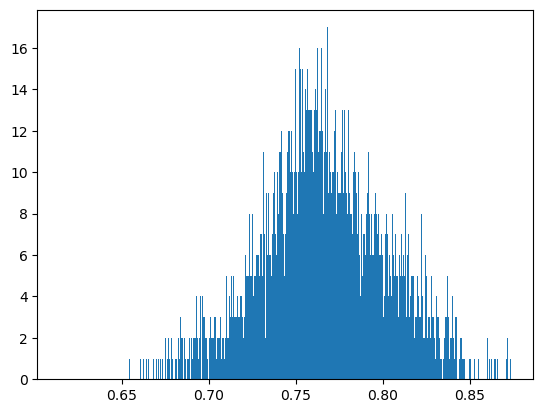

In [311]:
plt.hist(losses,bins=1000)[1]

In [341]:
import warnings
warnings.filterwarnings("ignore")

fits = [i.estimator.loss for i in stack]
a = [stack[i] for i in np.argsort(fits)]

lam = 100
log_odds,p = initial_first_bin(init_log_odds,init_p,X_train)
test_log_odds,test_p = initial_first_bin(init_log_odds,init_p,X_test)

train_acc = []
test_acc = []


train_sse = []
test_sse = []

counts = []


for i,node in enumerate(a):
    node.estimator.lam = lam
    grads = node.estimator.set_grads_bin(y_train_one_hot-p,p)
    log_odds,p = update_log_p(grads,log_odds,p,learning_rate)

    test_grads = node.predict_grad(X_test)
    test_log_odds,test_p = update_log_p(test_grads,test_log_odds,test_p,learning_rate)


    train_sse.append(np.sum(np.power(y_train_one_hot - p,2)))
    test_sse.append(np.sum(np.power(y_test_one_hot - test_p,2)))
    print(train_sse[-1],test_sse[-1],i+1,len(a))


    pred = np.argmax(p,axis=1)
    train_acc.append(f1_score(pred,y_train,average='macro'))
    test_pred = np.argmax(test_p,axis=1)
    test_acc.append(f1_score(test_pred,y_test,average='macro'))


    # pred = np.argmax(p,axis=1)
    # train_acc.append(accuracy_score(pred,y_train))
    # test_pred = np.argmax(test_p,axis=1)
    # test_acc.append(accuracy_score(test_pred,y_test))

    print('\t',train_acc[-1],test_acc[-1],i+1,len(a))
    

68189.2204665245 68250.58566442343 1 3135
	 0.3145912488359246 0.31617895734959134 1 3135
46833.19451573429 46877.60124616892 2 3135
	 0.34405040373248363 0.3428845480289967 2 3135
35255.462130477055 35271.05044105694 3 3135
	 0.3613433268446148 0.36266721044992634 3 3135
28719.610621455806 28717.33618285527 4 3135
	 0.42466268770500126 0.42228782361081063 4 3135
24789.77501807251 24781.048340140485 5 3135
	 0.41932033336910524 0.41634942299519295 5 3135
21603.991566406014 21594.595145022657 6 3135
	 0.4233891738801643 0.41901750361815526 6 3135
20078.924973130823 20063.54020824689 7 3135
	 0.42690283912188587 0.42373711245519874 7 3135
19055.39311983452 19038.38681253525 8 3135
	 0.42789996295977295 0.4249142994950501 8 3135
17685.713369585992 17670.22503247202 9 3135
	 0.4423007965982543 0.43771337970957547 9 3135
17281.58105869048 17265.625168129336 10 3135
	 0.4527384900417809 0.4497662328224561 10 3135
16787.390824069516 16777.888239680447 11 3135
	 0.4556311967867747 0.4537166819

In [295]:
#balance acc
i = -1

print(sum([n.numNode for n in stack[:i]]),train_acc[i],test_acc[i])

26836 0.8355726206711211 0.5535920496749418


In [300]:
#balance acc
i = 2700

print(sum([n.numNode for n in stack[:i]]),train_acc[i],test_acc[i])

21696 0.8208192149538688 0.5501348036580538


In [301]:
print(classification_report(y_train,np.argmax(p,axis=1),digits=5))

              precision    recall  f1-score   support

           0    1.00000   1.00000   1.00000         4
           1    0.99995   0.99843   0.99919     21058
           2    0.72740   0.77826   0.75197      7536
           3    0.97931   0.94667   0.96271       150
           4    0.87714   0.98980   0.93007     10004
           5    0.65111   0.70698   0.67790      6945
           6    0.77082   0.34356   0.47528      4337
           7    0.85714   0.92000   0.88746       450

    accuracy                        0.86665     50484
   macro avg    0.85786   0.83546   0.83557     50484
weighted avg    0.86592   0.86665   0.85828     50484



In [302]:

print(classification_report(y_test,np.argmax(test_p,axis=1),digits=5))

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         5
           1    0.99976   0.99905   0.99941     21058
           2    0.57882   0.64411   0.60972      7536
           3    0.63514   0.31544   0.42152       149
           4    0.85937   0.97441   0.91328     10003
           5    0.47290   0.50382   0.48787      6945
           6    0.42557   0.17731   0.25033      4337
           7    0.76212   0.73171   0.74661       451

    accuracy                        0.79796     50484
   macro avg    0.59171   0.54323   0.55359     50484
weighted avg    0.78400   0.79796   0.78538     50484



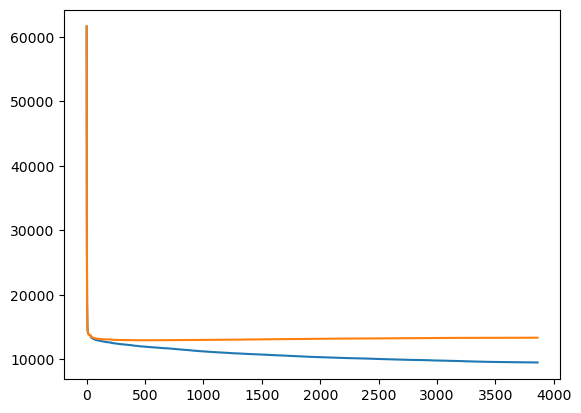

In [307]:
plt.plot(train_sse)
plt.plot(test_sse)

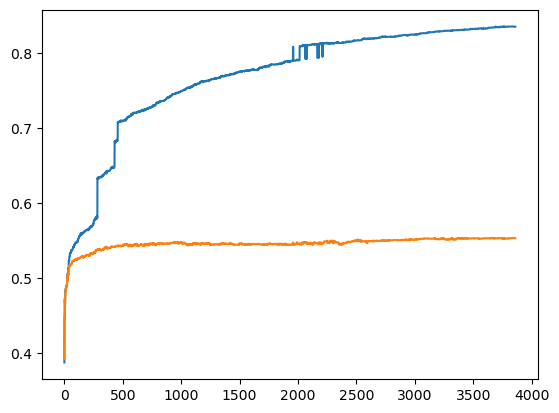

In [308]:
plt.plot(train_acc)
plt.plot(test_acc)

In [284]:
import xgboost

xgb = xgboost.XGBClassifier()
xgb.fit(X_train,y_train)

pred = xgb.predict_proba(X_train)

pred = np.argmax(pred,axis=1)
print(classification_report(y_train,pred,digits=3))

# pred = xgb.predict_proba(X_train)
# pred = pred[:,1]
# print(roc_auc_score(y_train,pred))

pred = xgb.predict_proba(X_test)

pred = np.argmax(pred,axis=1)
print(classification_report(y_test,pred,digits=5))
print(balanced_accuracy_score(y_test,pred))

# pred = xgb.predict_proba(X_test)
# pred = pred[:,1]
# print(roc_auc_score(y_test,pred))

import json

def item_generator(json_input, lookup_key):
    if isinstance(json_input, dict):
        for k, v in json_input.items():
            if k == lookup_key:
                yield v
            else:
                yield from item_generator(v, lookup_key)
    elif isinstance(json_input, list):
        for item in json_input:
            yield from item_generator(item, lookup_key)

def tree_depth(json_text):
    json_input = json.loads(json_text)
    depths = list(item_generator(json_input, 'depth'))
    return max(depths) + 1 if len(depths) != 0 else 1


booster = xgb.get_booster()

tree_df = booster.trees_to_dataframe()
depths = [tree_depth(x) for x in booster.get_dump(dump_format = "json")]
len(depths),np.average(depths),len(tree_df)

              precision    recall  f1-score   support

           0      1.000     0.750     0.857         4
           1      1.000     0.998     0.999     21058
           2      0.692     0.728     0.710      7536
           3      0.922     0.793     0.853       150
           4      0.870     0.991     0.927     10004
           5      0.583     0.685     0.630      6945
           6      0.762     0.238     0.363      4337
           7      0.856     0.913     0.884       450

    accuracy                          0.847     50484
   macro avg      0.836     0.762     0.778     50484
weighted avg      0.849     0.847     0.835     50484

              precision    recall  f1-score   support

           0    0.00000   0.00000   0.00000         5
           1    0.99990   0.99905   0.99948     21058
           2    0.58940   0.63774   0.61262      7536
           3    0.56667   0.34228   0.42678       149
           4    0.85784   0.98031   0.91499     10003
           5    0.46629 

(800, 5.35375, 39066)